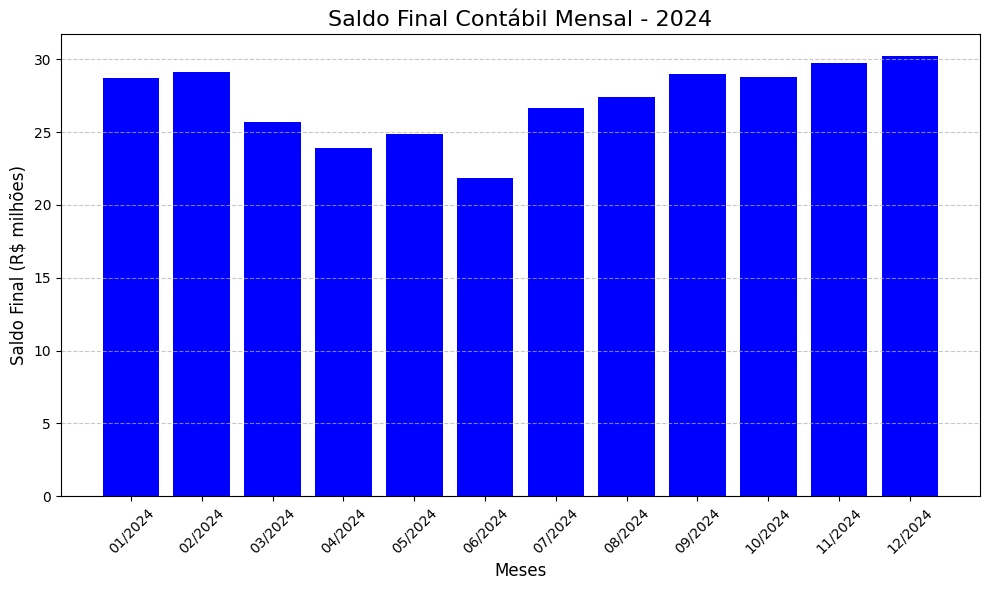

In [1]:
import requests
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Configurações do serviço SOAP
url = "https://gaivota.dealernetworkflow.com.br/aws_dealernetgateway.aspx"
headers = {
    "Content-Type": "text/xml; charset=utf-8",
}

# Função para gerar o corpo da requisição para um intervalo de datas específico
def gerar_soap_body(data_inicial, data_final):
    return f"""
    <soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:deal="DealerNet">
       <soapenv:Header/>
       <soapenv:Body>
          <deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
             <deal:Usuario_identificador>portus</deal:Usuario_identificador>
             <deal:Usuariosenha_senha>Portus25@</deal:Usuariosenha_senha>
             <deal:Empresa_codigo>1</deal:Empresa_codigo>
             <deal:Dtini>{data_inicial}</deal:Dtini>
             <deal:Dtfin>{data_final}</deal:Dtfin>
          </deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
       </soapenv:Body>
    </soapenv:Envelope>
    """

# Função para extrair o saldo final do XML de resposta
def extrair_saldo_final(response_xml):
    namespaces = {
        "soapenv": "http://schemas.xmlsoap.org/soap/envelope/",
        "deal": "DealerNet",
    }
    root = ET.fromstring(response_xml)
    cdata_section = root.find(
        ".//deal:WS_DealernetGateway.CONSULTASALDOCONTABILResponse/deal:Xml_retorno",
        namespaces
    )
    if cdata_section is not None and cdata_section.text:
        cdata_content = cdata_section.text.strip()
        cdata_root = ET.fromstring(cdata_content)
        saldo_final = cdata_root.find(".//SaldoFinal")
        return float(saldo_final.text) if saldo_final is not None else None
    return None

# Listas para armazenar os meses e os saldos finais
meses = []
saldos_finais = []

# Fazer consultas para cada mês de 2024
for mes in range(1, 13):
    data_inicial = f"2024-{mes:02d}-01"
    data_final = f"2024-{mes:02d}-28"  # Ajuste simples para evitar dias inválidos
    soap_body = gerar_soap_body(data_inicial, data_final)
    
    # Fazer a requisição
    response = requests.post(url, data=soap_body, headers=headers)
    if response.status_code == 200:
        saldo_final = extrair_saldo_final(response.content)
        if saldo_final is not None:
            meses.append(f"{mes:02d}/2024")
            saldos_finais.append(saldo_final)
        else:
            print(f"Saldo final não encontrado para o mês {mes}.")
    else:
        print(f"Erro ao consultar o mês {mes}: {response.status_code}")

# Converter saldos finais para milhões
saldos_finais_milhoes = [saldo / 1_000_000 for saldo in saldos_finais]

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(meses, saldos_finais_milhoes, color='blue')
plt.title("Saldo Final Contábil Mensal - 2024", fontsize=16)
plt.xlabel("Meses", fontsize=12)
plt.ylabel("Saldo Final (R$ milhões)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [6]:
import requests
import xml.etree.ElementTree as ET

# Configurações do serviço SOAP
url = "https://gaivota.dealernetworkflow.com.br/aws_dealernetgateway.aspx"
headers = {
    "Content-Type": "text/xml; charset=utf-8",
}

# Função para consultar um campo específico
def consultar_campo(empresa_codigo, mes, ano, campo_desejado):
    """
    Consulta um campo específico para um mês e empresa específicos.

    :param empresa_codigo: Código da empresa.
    :param mes: Mês da consulta (1-12).
    :param ano: Ano da consulta.
    :param campo_desejado: Nome do campo a ser buscado (ex.: "SaldoFinal").
    :return: Valor do campo encontrado ou None se não encontrado.
    """
    # Gerar intervalo de datas
    data_inicial = f"{ano}-{mes:02d}-01"
    data_final = f"{ano}-{mes:02d}-30"  # Ajuste simples para evitar dias inválidos

    # Corpo da requisição SOAP
    soap_body = f"""
    <soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:deal="DealerNet">
       <soapenv:Header/>
       <soapenv:Body>
          <deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
             <deal:Usuario_identificador>portus</deal:Usuario_identificador>
             <deal:Usuariosenha_senha>Portus25@</deal:Usuariosenha_senha>
             <deal:Empresa_codigo>{empresa_codigo}</deal:Empresa_codigo>
             <deal:Dtini>{data_inicial}</deal:Dtini>
             <deal:Dtfin>{data_final}</deal:Dtfin>
          </deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
       </soapenv:Body>
    </soapenv:Envelope>
    """

    # Fazer a requisição SOAP
    response = requests.post(url, data=soap_body, headers=headers)
    if response.status_code == 200:
        namespaces = {
            "soapenv": "http://schemas.xmlsoap.org/soap/envelope/",
            "deal": "DealerNet",
        }
        root = ET.fromstring(response.content)
        cdata_section = root.find(
            ".//deal:WS_DealernetGateway.CONSULTASALDOCONTABILResponse/deal:Xml_retorno",
            namespaces
        )
        if cdata_section is not None and cdata_section.text:
            # Parsear o conteúdo do CDATA como XML
            cdata_content = cdata_section.text.strip()
            cdata_root = ET.fromstring(cdata_content)
            # Procurar pelo campo desejado
            campo = cdata_root.find(f".//{campo_desejado}")
            return campo.text if campo is not None else None
    else:
        print(f"Erro na requisição: {response.status_code}")
        print(response.text)
    return None

# Exemplo de uso da função
empresa = 1
mes = 11
ano = 2024
campo = "SaldoFinal"

resultado = consultar_campo(empresa, mes, ano, campo)
if resultado is not None:
    print(f"Valor do campo '{campo}' para empresa {empresa}, mês {mes}/{ano}: {resultado}")
else:
    print(f"Campo '{campo}' não encontrado para empresa {empresa}, mês {mes}/{ano}.")


Valor do campo 'SaldoFinal' para empresa 1, mês 11/2024: 28953320.26


In [24]:
import requests
import xml.etree.ElementTree as ET
import numpy as np

# URL do serviço SOAP
url = "https://gaivota.dealernetworkflow.com.br/aws_dealernetgateway.aspx"

# Cabeçalhos HTTP
headers = {
    "Content-Type": "text/xml; charset=utf-8",
}

# Corpo da requisição SOAP
soap_body = """
<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:deal="DealerNet">
   <soapenv:Header/>
   <soapenv:Body>
      <deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
         <deal:Usuario_identificador>portus</deal:Usuario_identificador>
         <deal:Usuariosenha_senha>Portus25@</deal:Usuariosenha_senha>
         <deal:Empresa_codigo>1</deal:Empresa_codigo>
         <deal:Dtini>2024-11-01</deal:Dtini>
         <deal:Dtfin>2024-11-30</deal:Dtfin>
      </deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
   </soapenv:Body>
</soapenv:Envelope>
"""

# Fazer a requisição SOAP
response = requests.post(url, data=soap_body, headers=headers)

# Verificar se a resposta é válida
if response.status_code == 200:
    # Parsear o XML da resposta
    root = ET.fromstring(response.content)

    # Namespaces do XML
    namespaces = {
        "soapenv": "http://schemas.xmlsoap.org/soap/envelope/",
        "deal": "DealerNet",
    }

    # Função para extrair valores das contas específicas
    def obter_valor_conta(cdata_root, conta_id):
        """
        Obtém o saldo final de uma conta específica pelo seu ID.

        :param cdata_root: Raiz do CDATA parseado.
        :param conta_id: ID da conta a ser buscada.
        :return: Saldo Final da conta (float) ou None se não encontrado.
        """
        for item in cdata_root.findall(".//SDT_SaldoContabilItem"):
            if item.find("ContaIDNivel").text == conta_id:
                saldo_inicial = item.find("SaldoInicial").text
                saldo_final = item.find("SaldoFinal").text
                return np.round(float(saldo_final) - float(saldo_inicial), 2)
        return None

    # Localizar o CDATA com os dados de contas
    body = root.find("soapenv:Body", namespaces)
    response = body.find("deal:WS_DealernetGateway.CONSULTASALDOCONTABILResponse", namespaces)
    xml_retorno = response.find("deal:Xml_retorno", namespaces)

    # Parse do CDATA
    if xml_retorno is not None and xml_retorno.text:
        cdata_content = xml_retorno.text.strip()
        cdata_root = ET.fromstring(cdata_content)

        # Lista de contas para calcular as métricas
        contas = [
            {"nome": "VN Passageiros", "receita": "3.1.1.001.000001", "custo": "3.3.1.001.000001"},
            {"nome": "VN Comerciais Leves", "receita": "3.1.1.001.000002", "custo": "3.3.1.001.000002"},
            {"nome": "Seminovos", "receita": "3.1.1.002.000001", "custo": "3.3.1.002.000001"},
            {"nome": "Peças Atacado", "receita": "3.1.1.003.000001", "custo": "3.3.1.003.000001"},
            {"nome": "Peças Varejo", "receita": "3.1.1.003.000002", "custo": "3.3.1.003.000002"},
            {"nome": "Peças Mecânica", "receita": "3.1.1.003.000003", "custo": "3.3.1.003.000003"},
            {"nome": "Peças Funilaria e Pintura", "receita": "3.1.1.003.000004", "custo": "3.3.1.003.000004"},
            {"nome": "Peças Garantia", "receita": "3.1.1.003.000005", "custo": "3.3.1.003.000005"},
            {"nome": "Peças Interna", "receita": "3.1.1.003.000006", "custo": "3.3.1.003.000006"},
            {"nome": "Acessórios", "receita": "3.1.1.003.000007", "custo": "3.3.1.003.000007"},
            {"nome": "Combustíveis e Lubrificantes", "receita": "3.1.1.003.000008", "custo": "3.3.1.003.000008"},
            {"nome": "Pneus e Câmaras", "receita": "3.1.1.003.000009", "custo": "3.3.1.003.000009"},
        ]

        # Calcular métricas para cada conta
        for conta in contas:
            valor_receita = obter_valor_conta(cdata_root, conta["receita"])
            valor_custo = obter_valor_conta(cdata_root, conta["custo"])

            if valor_receita is not None and valor_custo is not None:
                resultado = -valor_receita - valor_custo
                margem = -resultado / valor_receita * 100
                print(f"\n{conta['nome']}:")
                print(f"  Receita: R$ {valor_receita:.2f}")
                print(f"  Custo: R$ {valor_custo:.2f}")
                print(f"  Resultado: R$ {resultado:.2f}")
                print(f"  Margem Bruta: {margem:.2f}%")
            else:
                print(f"\nErro: Não foi possível calcular para {conta['nome']}.")
    else:
        print("Erro: Não foi possível localizar o CDATA com os dados.")
else:
    print(f"Erro na requisição: {response.status_code}")
    print(response.text)



VN Passageiros:
  Receita: R$ -2620230.00
  Custo: R$ 2527627.08
  Resultado: R$ 92602.92
  Margem Bruta: 3.53%

VN Comerciais Leves:
  Receita: R$ -744980.00
  Custo: R$ 605487.59
  Resultado: R$ 139492.41
  Margem Bruta: 18.72%

Seminovos:
  Receita: R$ -1370390.00
  Custo: R$ 1251500.00
  Resultado: R$ 118890.00
  Margem Bruta: 8.68%

Peças Atacado:
  Receita: R$ -31211.87
  Custo: R$ 25652.96
  Resultado: R$ 5558.91
  Margem Bruta: 17.81%

Peças Varejo:
  Receita: R$ -172559.38
  Custo: R$ 32266.74
  Resultado: R$ 140292.64
  Margem Bruta: 81.30%

Peças Mecânica:
  Receita: R$ -146927.53
  Custo: R$ 103012.91
  Resultado: R$ 43914.62
  Margem Bruta: 29.89%

Peças Funilaria e Pintura:
  Receita: R$ -46282.97
  Custo: R$ 29980.05
  Resultado: R$ 16302.92
  Margem Bruta: 35.22%

Peças Garantia:
  Receita: R$ -21927.13
  Custo: R$ 13489.87
  Resultado: R$ 8437.26
  Margem Bruta: 38.48%

Peças Interna:
  Receita: R$ -5820.93
  Custo: R$ 5817.82
  Resultado: R$ 3.11
  Margem Bruta: 0.05

In [10]:
import xml.etree.ElementTree as ET

# Carregar o XML retornado da requisição SOAP
with open("soap.xml", "r", encoding="utf-8") as file:
    xml_content = file.read()

# Parsear o XML
root = ET.fromstring(xml_content)

# Registrar namespaces
namespaces = {
    "soapenv": "http://schemas.xmlsoap.org/soap/envelope/",
    "deal": "DealerNet",
}

# Localizar o corpo principal do XML (namespace correto)
body = root.find("soapenv:Body", namespaces)
if body is not None:
    response = body.find("deal:WS_DealernetGateway.CONSULTASALDOCONTABILResponse", namespaces)
    if response is not None:
        xml_retorno = response.find("deal:Xml_retorno", namespaces)
        if xml_retorno is not None and xml_retorno.text:
            # Parsear o CDATA interno
            cdata_content = xml_retorno.text.strip()
            cdata_root = ET.fromstring(cdata_content)

            # Verificar os elementos `SDT_SaldoContabilItem`
            print("Listando contas encontradas no XML:")
            for item in cdata_root.findall(".//SDT_SaldoContabilItem"):
                conta_id = item.find("ContaIDNivel").text
                descricao = item.find("ContaDescricao").text
                saldo_final = item.find("SaldoFinal").text
                print(f"ID: {conta_id}, Descrição: {descricao}, Saldo Final: {saldo_final}")
        else:
            print("Erro: Elemento `deal:Xml_retorno` não encontrado ou vazio.")
    else:
        print("Erro: Elemento `deal:WS_DealernetGateway.CONSULTASALDOCONTABILResponse` não encontrado.")
else:
    print("Erro: Elemento `soapenv:Body` não encontrado.")


Listando contas encontradas no XML:
ID: 1, Descrição: A T I V O, Saldo Final: 28953320.26
ID: 1.1, Descrição: ATIVO CIRCULANTE, Saldo Final: 23840282.35
ID: 1.1.1, Descrição: DISPONIBILIDADES, Saldo Final: 1353373.94
ID: 1.1.1.001, Descrição: CAIXA, Saldo Final: 193538.03
ID: 1.1.1.001.000001, Descrição: CAIXA 301.01 - GERAL TESOURARIA, Saldo Final: 135457.52
ID: 1.1.1.001.000002, Descrição: CAIXA 301.02 - LOJA, Saldo Final: 310.00
ID: 1.1.1.001.000003, Descrição: CAIXA 301.03 - VEICULOS, Saldo Final: 0.00
ID: 1.1.1.001.000004, Descrição: CAIXA 301.04 - MERCADO LIVRE, Saldo Final: 57770.51
ID: 1.1.1.002, Descrição: BANCOS CONTA MOVIMENTO, Saldo Final: 853256.50
ID: 1.1.1.002.000002, Descrição: BCO BRASIL ARARAS CC 6244-8  AG 0341-7, Saldo Final: 0.00
ID: 1.1.1.002.000004, Descrição: BCO ITAU CC  00012-0  AG  7372, Saldo Final: 841584.76
ID: 1.1.1.002.000007, Descrição: BCO SANTANDER CC:0130003377 AG:3540, Saldo Final: -4773.54
ID: 1.1.1.002.000009, Descrição: BCO CEF ARARAS CC:414 AG:0